# Evaluation and plotting for different experiments

- Write throughput (fio vs dd, isilon vs netapp)
- Containerized fio vs non-containerized fio

In [1]:
from __future__ import annotations
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import scipy.stats as st
from datetime import datetime, timedelta

In [2]:
METRIC = {
    "throughput_write": "write_bw_mean_in_MiB",
    "iops_write": "write_iops_mean",
    "latency_write": "write_lat_mean_in_ms",
    "throughput_read": "read_bw_mean_in_MiB",
    "iops_read": "read_iops_mean",
    "latency_read": "read_lat_mean_in_ms",
}

def load_data(filename: Path | str, metric: str, suffix: str="", x_labels=None) -> pd.DataFrame:
    """Load data either from file or from multiple files placed in a directory"""
    path = Path(filename)
    if path.is_file():
        data = load_json(path)
    elif path.is_dir():
        data = load_dir(path, suffix)
    else:
        data = load_json(str(path)+suffix)
    return extract_results(data, metric, x_labels)

def load_json(filename: Path | str) -> dict:
    """Load file as json"""
    file = Path(filename)
    assert file.is_file(), f"{file} is not a file"
    return json.loads(file.read_text())

def load_dir(path: Path, suffix: str) -> dict:
    """Combine results of multiple files in directory. Specify files by suffix"""
    res = {"results":{}}

    for file in path.glob(f"*{suffix}"):
        data = load_json(file)

        for key, value in data["results"].items():
            if key not in res["results"]:
                res["results"][key] = []
            res["results"][key].extend(value)

    return res

def extract_results(data, metric, x_labels=None):
    x_labels = x_labels if x_labels else list(data["results"].keys())
    pd_data = []
    for label in x_labels:
        results = data["results"][label]
        values = [float(r[metric]) for r in results]
        values = [v for v in values if v > 0]
        mean = np.mean(values)
        conf = confidence_interval(values)
        std = np.std(values)
        num = len(values)
        pd_data.append([mean, std, num])


    df = pd.DataFrame(data=pd_data, index=x_labels, columns=["mean", "std", "num"])
    df.rename(index={"1024": 1, "2048": 2, "4096": 4, "8192": 8, "16384": 16}, inplace=True)
    df.rename(index={"256M": 0.25, "1G": 1, "2G": 2, "4G": 4, "8G": 8, "16G": 16}, inplace=True)
    df.rename(index={"1k": 1, "4k": 4, "16k": 16, "64k": 64, "256k": 256, "1024k": 1024, "4096k": 4096, "16384k": 16384}, inplace=True)
    df.rename(index={"1": 1, "2": 2, "4": 4, "8": 8, "16": 16, "32": 32}, inplace=True)
    df.rename(index={"10": 10, "20": 20, "60": 60, "120": 120, "300": 300}, inplace=True)

    return df

def confidence_interval(values):
    confidence = 0.95
    dof = len(values)-1
    m = np.mean(values)
    sem = st.sem(values)
    interval = st.t.interval(alpha=confidence, df=dof, loc=m, scale=sem)
    if np.isnan(interval[0]) or np.isnan(interval[1]):
        return m * 10**-6
    return (interval[1]-interval[0])/2
    
def plot(filename, metric="write_bw_mean_in_mb"):
    data = load_json(filename)
    df = extract_results(data, metric=metric)
    print(df)
    ax = df["mean"].plot(kind='bar', rot=0, xlabel='Date', ylabel='Value', title='My Plot', figsize=(6, 4), yerr=df["conf"])
    plt.show()

def tex_table(lst):
    for item in lst:
        print(*item, sep=" & ", end="\\\\\n")

# Experiment: Parameter-evaluation: dd

<IPython.core.display.Javascript object>


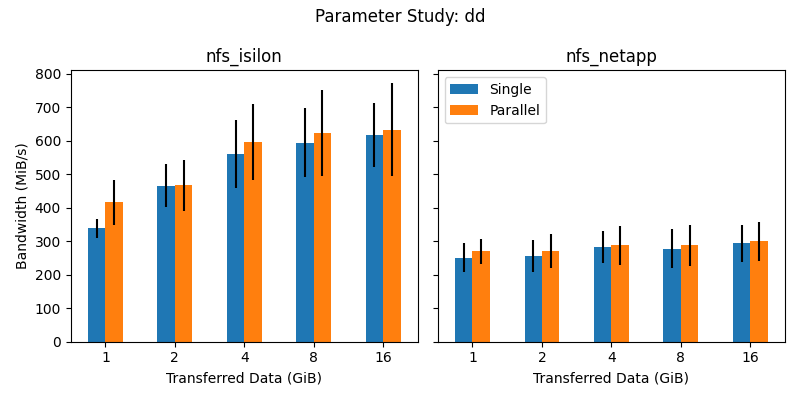

In [3]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_dd_")
folder = Path("./results/param_study_dd")

## Plot code
path = file_prefix if file_prefix else folder

df_isilon = pd.concat({
    "Single": load_data(path, metric="bw_in_MiB", suffix="isilon_a.json"),
    "Parallel": load_data(path, metric="bw_in_MiB", suffix="isilon_b.json"),
})

df_netapp = pd.concat({
    "Single": load_data(path, metric="bw_in_MiB", suffix="netapp_a.json"),
    "Parallel": load_data(path, metric="bw_in_MiB", suffix="netapp_b.json"),
})

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Parameter Study: dd')

df_isilon["mean"].unstack(level=0)[["Single","Parallel"]].plot(
    ax=ax1,
    kind='bar', rot=0,
    xlabel='Transferred Data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"nfs_isilon",
    figsize=(8, 4),
    yerr=df_isilon["std"].unstack(level=0)[["Single","Parallel"]]
)

df_netapp["mean"].unstack(level=0)[["Single","Parallel"]].plot(
    ax=ax2,
    kind='bar', rot=0,
    xlabel='Transferred Data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"nfs_netapp",
    figsize=(8, 4),
    yerr=df_netapp["std"].unstack(level=0)[["Single","Parallel"]],
)

ax1.get_legend().remove()
ax2.legend(loc="upper left")
plt.tight_layout()
plt.savefig("paramstudy_dd.png",bbox_inches='tight')
plt.show()


# Experiment: Parameter-evaluation: Fio

<IPython.core.display.Javascript object>


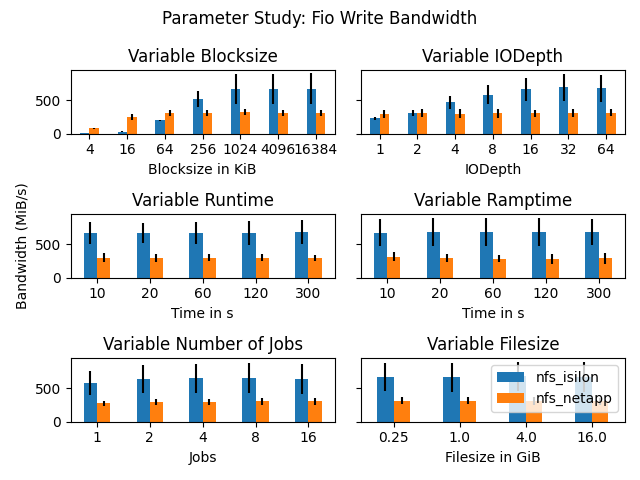

In [4]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-05-17T21:18:41_throughput_write_")
folder = Path("./results/param_study_fio_throughput")

## Plot code
path = file_prefix if file_prefix else folder


post_i = "_isilon.json"
post_n = "_netapp.json"
metric = METRIC["throughput_write"]

df_1 = pd.concat({
    "nfs_isilon": load_data(path, suffix="blocksize"+post_i, metric=metric),
    "nfs_netapp": load_data(path, suffix="blocksize"+post_n, metric=metric),
})
df_2 = pd.concat({
    "nfs_isilon": load_data(path, suffix="iodepth"+post_i, metric=metric),
    "nfs_netapp": load_data(path, suffix="iodepth"+post_n, metric=metric),
})
df_3 = pd.concat({
    "nfs_isilon": load_data(path, suffix="runtime"+post_i, metric=metric),
    "nfs_netapp": load_data(path, suffix="runtime"+post_n, metric=metric),
})
df_4 = pd.concat({
    "nfs_isilon": load_data(path, suffix="ramptime"+post_i, metric=metric),
    "nfs_netapp": load_data(path, suffix="ramptime"+post_n, metric=metric),
})
df_5 = pd.concat({
    "nfs_isilon": load_data(path, suffix="numjobs"+post_i, metric=metric),
    "nfs_netapp": load_data(path, suffix="numjobs"+post_n, metric=metric),
})
df_6 = pd.concat({
    "nfs_isilon": load_data(path, suffix="filesize"+post_i, metric=metric),
    "nfs_netapp": load_data(path, suffix="filesize"+post_n, metric=metric),
})

fig, axis = plt.subplots(3, 2, sharey=True)
fig.suptitle('Parameter Study: Fio Write Bandwidth')

    
df_1["mean"].unstack(level=0).plot(
    ax=axis[0][0],
    kind='bar', rot=0,
    xlabel='Blocksize in KiB',
    title='Variable Blocksize',
    yerr=df_1["std"].unstack(level=0)
)
df_2["mean"].unstack(level=0).plot(
    ax=axis[0][1],
    kind='bar', rot=0,
    xlabel='IODepth',
    title='Variable IODepth',
    yerr=df_2["std"].unstack(level=0)
)

df_3["mean"].unstack(level=0).plot(
    ax=axis[1][0],
    kind='bar', rot=0,
    xlabel='Time in s',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Runtime',
    yerr=df_3["std"].unstack(level=0)
)

df_4["mean"].unstack(level=0).plot(
    ax=axis[1][1],
    kind='bar', rot=0,
    xlabel='Time in s',
    title='Variable Ramptime',
    yerr=df_4["std"].unstack(level=0)
)
df_5["mean"].unstack(level=0).plot(
    ax=axis[2][0],
    kind='bar', rot=0,
    xlabel='Jobs',
    title='Variable Number of Jobs',
    yerr=df_5["std"].unstack(level=0)
)
df_6["mean"].unstack(level=0).plot(
    ax=axis[2][1],
    kind='bar', rot=0,
    xlabel='Filesize in GiB',
    title='Variable Filesize',
    yerr=df_6["std"].unstack(level=0)
)
for i,j in [(0,0),(0,1),(1,0),(1,1),(2,0)]:
    axis[i][j].get_legend().remove()
    
plt.tight_layout()
plt.savefig("paramstudy_fio_throughput.png",bbox_inches='tight')
plt.show()


<IPython.core.display.Javascript object>


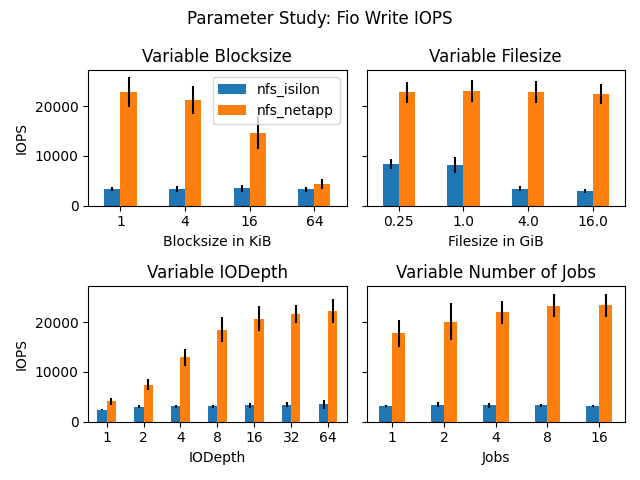

In [5]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T22:22:50_iops_write_")
folder = Path("./results/param_study_fio_iops")

## Plot code
path = file_prefix if file_prefix else folder


post_i = "_isilon.json"
post_n = "_netapp.json"
metric = METRIC["iops_write"]

df_1 = pd.concat({
    "nfs_isilon": load_data(path, suffix="blocksize"+post_i, metric=metric),
    "nfs_netapp": load_data(path, suffix="blocksize"+post_n, metric=metric),
})
df_2 = pd.concat({
    "nfs_isilon": load_data(path, suffix="filesize"+post_i, metric=metric),
    "nfs_netapp": load_data(path, suffix="filesize"+post_n, metric=metric),
})
df_3 = pd.concat({
    "nfs_isilon": load_data(path, suffix="iodepth"+post_i, metric=metric),
    "nfs_netapp": load_data(path, suffix="iodepth"+post_n, metric=metric),
})
df_4 = pd.concat({
    "nfs_isilon": load_data(path, suffix="numjobs"+post_i, metric=metric),
    "nfs_netapp": load_data(path, suffix="numjobs"+post_n, metric=metric),
})

fig, axis = plt.subplots(2, 2, sharey=True)
fig.suptitle('Parameter Study: Fio Write IOPS')

    
df_1["mean"].unstack(level=0).plot(
    ax=axis[0][0],
    kind='bar', rot=0,
    xlabel='Blocksize in KiB',
    ylabel='IOPS',
    title='Variable Blocksize',
    yerr=df_1["std"].unstack(level=0)
)
df_2["mean"].unstack(level=0).plot(
    ax=axis[0][1],
    kind='bar', rot=0,
    xlabel='Filesize in GiB',
    title='Variable Filesize',
    yerr=df_2["std"].unstack(level=0)
)

df_3["mean"].unstack(level=0).plot(
    ax=axis[1][0],
    kind='bar', rot=0,
    xlabel='IODepth',
    ylabel='IOPS',
    title='Variable IODepth',
    yerr=df_3["std"].unstack(level=0)
)

df_4["mean"].unstack(level=0).plot(
    ax=axis[1][1],
    kind='bar', rot=0,
    xlabel='Jobs',
    title='Variable Number of Jobs',
    yerr=df_4["std"].unstack(level=0)
)

for i,j in [(0,1),(1,0),(1,1)]:
    axis[i][j].get_legend().remove()
    
plt.tight_layout()
plt.savefig("paramstudy_fio_iops.png",bbox_inches='tight')
plt.show()


# Experiment: Parameter-evaluation: MDTest

<IPython.core.display.Javascript object>


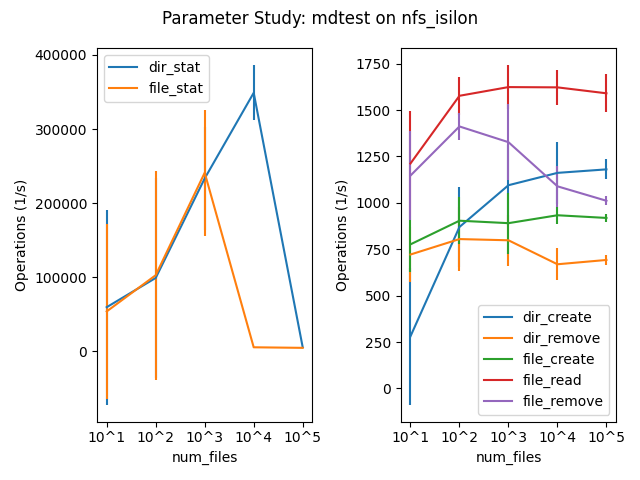

                       mean         std  num
dir_create 10^1   280.55660  367.812856   20
           10^2   870.04705  214.024901   20
           10^3  1095.08435  216.723094   20
           10^4  1161.64235  166.196069   20
           10^5  1180.50980   53.700815   20
                       mean            std  num
dir_stat 10^1   59722.32145  131417.670234   20
         10^2   99183.02005  135083.384508   20
         10^3  233443.53515   69215.281521   20
         10^4  348868.19885   37224.326942   20
         10^5    5740.32620     776.724857   20
                      mean         std  num
dir_remove 10^1  721.58990  150.587023   20
           10^2  804.84300  174.153828   20
           10^3  798.34010  136.877770   20
           10^4  669.08225   85.009592   20
           10^5  692.32010   28.690286   20
                       mean         std  num
file_create 10^1  776.37855  151.638302   20
            10^2  903.83465  126.004420   20
            10^3  890.59460  164.678292   2

In [6]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-13T11:04:51_parameval_warp_")
folder = Path("./results/param_study_mdtest")

## Plot code
path = file_prefix if file_prefix else folder

metrics = [
    "dir_create",
    "dir_stat",
    "dir_remove",
    "file_create",
    "file_stat",
    "file_read",
    "file_remove",
    #"tree_create",
    #"tree_remove",
]
dfs = []

for metric in metrics:
    dfs.append(pd.concat({
        #"local": load_data(path, metric=metric, suffix="mdtest_local.json"),
        metric: load_data(path, metric=metric, suffix="mdtest_isilon.json"),
        #"nfs_netapp": load_data(path, metric=metric, suffix="mdtest_netapp.json"),
    }))
    dfs[-1].rename(index={10: "10^1", "100": "10^2", "1000": "10^3", "10000": "10^4", "100000": "10^5"}, inplace=True)

    

fig, axis = plt.subplots(1, 2)
fig.suptitle('Parameter Study: mdtest on nfs_isilon')

dfs[1]["mean"].unstack(level=0).plot(
    ax=axis[0],
    kind='line', rot=0,
    xlabel='num_files',
    ylabel='Operations (1/s)',
    yerr=dfs[1]["std"].unstack(level=0)
)
dfs[4]["mean"].unstack(level=0).plot(
    ax=axis[0],
    kind='line', rot=0,
    yerr=dfs[4]["std"].unstack(level=0)
)

dfs[0]["mean"].unstack(level=0).plot(
    ax=axis[1],
    kind='line', rot=0,
    xlabel='num_files',
    ylabel='Operations (1/s)',
    yerr=dfs[0]["std"].unstack(level=0)
)

dfs[2]["mean"].unstack(level=0).plot(
    ax=axis[1],
    kind='line', rot=0,
    yerr=dfs[2]["std"].unstack(level=0)
)
dfs[3]["mean"].unstack(level=0).plot(
    ax=axis[1],
    kind='line', rot=0,
    yerr=dfs[3]["std"].unstack(level=0)
)
dfs[5]["mean"].unstack(level=0).plot(
    ax=axis[1],
    kind='line', rot=0,
    yerr=dfs[5]["std"].unstack(level=0)
)
dfs[6]["mean"].unstack(level=0).plot(
    ax=axis[1],
    kind='line', rot=0,
    yerr=dfs[6]["std"].unstack(level=0)
)
#dfs[7]["mean"].unstack(level=0).plot(
#    ax=axis[1],
#    kind='line', rot=0,
#    yerr=dfs[7]["std"].unstack(level=0)
#)
#dfs[8]["mean"].unstack(level=0).plot(
#    ax=axis[1],
#    kind='line', rot=0,
#    yerr=dfs[8]["std"].unstack(level=0)
#)


for df in dfs:
    print(df)

plt.tight_layout()
plt.savefig("paramstudy_mdtest.png",bbox_inches='tight')
plt.show()

# Experiment: Parameter-evaluation: s3-benchmark

<IPython.core.display.Javascript object>


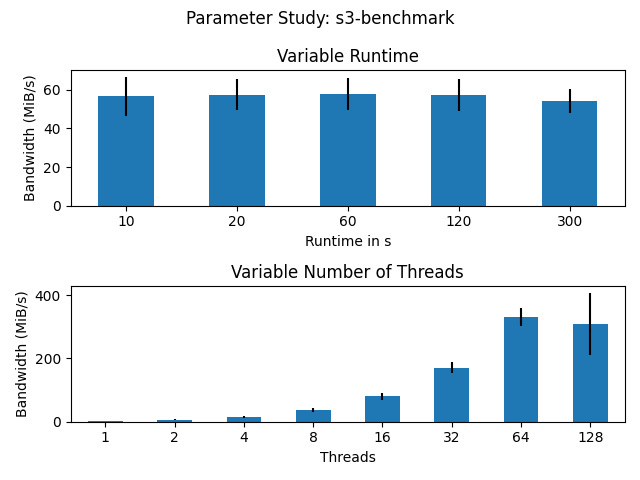

In [7]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-17T20:00:04_parameval_s3benchmark_")
folder = Path("./results/param_study_s3benchmark")

## Plot code
path = file_prefix if file_prefix else folder

metric = "put_bw_in_mibi"
df_1 = load_data(path, suffix="runtime.json", metric=metric)
df_2 = load_data(path, suffix="threads.json", metric=metric, x_labels=["1", "2", "4", "8", "16", "32", "64", "128"])

fig, axis = plt.subplots(2, 1)
fig.suptitle('Parameter Study: s3-benchmark')

    
df_1["mean"].plot(
    ax=axis[0],
    kind='bar', rot=0,
    xlabel='Runtime in s',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Runtime',
    yerr=df_1["std"]
)
df_2["mean"].plot(
    ax=axis[1],
    kind='bar', rot=0,
    xlabel='Threads',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Number of Threads',
    yerr=df_2["std"]
)

plt.tight_layout()
plt.savefig("paramstudy_s3benchmark.png",bbox_inches='tight')
plt.show()


# Experiment: Parameter-evaluation: Warp

<IPython.core.display.Javascript object>


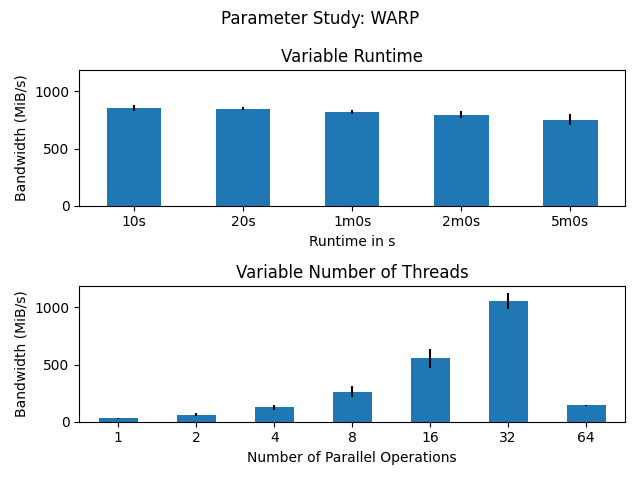

In [8]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-13T11:04:51_parameval_warp_")
folder = Path("./results/param_study_warp")

## Plot code
path = file_prefix if file_prefix else folder

metric = "put_bw_in_MiB"
df_1 = load_data(path, suffix="runtime.json", metric=metric)
df_2 = load_data(path, suffix="concurrent.json", metric=metric, x_labels=["1", "2", "4", "8", "16", "32", "64"])

fig, axis = plt.subplots(2, 1, sharey=True)
fig.suptitle('Parameter Study: WARP')

    
df_1["mean"].plot(
    ax=axis[0],
    kind='bar', rot=0,
    xlabel='Runtime in s',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Runtime',
    yerr=df_1["std"]
)
df_2["mean"].plot(
    ax=axis[1],
    kind='bar', rot=0,
    xlabel='Number of Parallel Operations',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Number of Threads',
    yerr=df_2["std"]
)

plt.tight_layout()
plt.savefig("paramstudy_warp.png",bbox_inches='tight')
plt.show()


# Experiment: Compare dd and fio

<IPython.core.display.Javascript object>


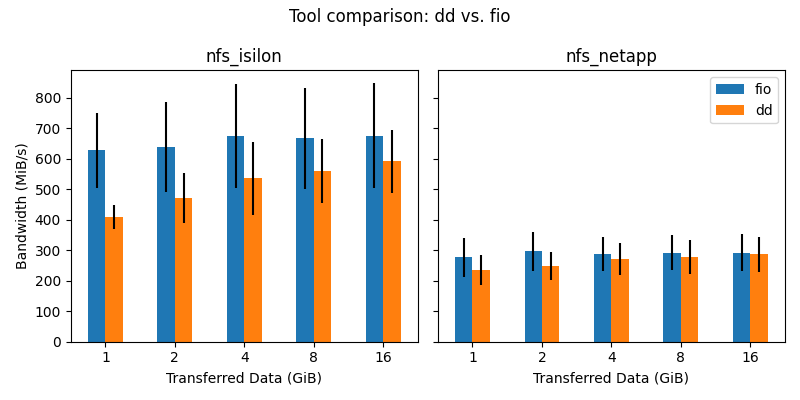

In [9]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_")
folder = Path("./results/compare_dd_vs_fio")

## Plot code
path = file_prefix if file_prefix else folder

df_isilon = pd.concat({
    "fio": load_data(path, metric="write_bw_mean_in_MiB", suffix="isilon_a.json"),
    "dd": load_data(path, metric="bw_in_MiB", suffix="isilon_b.json"),
})

df_netapp = pd.concat({
    "fio": load_data(path, metric="write_bw_mean_in_MiB", suffix="netapp_a.json"),
    "dd": load_data(path, metric="bw_in_MiB", suffix="netapp_b.json"),
})

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Tool comparison: dd vs. fio')

df_isilon["mean"].unstack(level=0).plot(
    ax=ax1,
    kind='bar', rot=0,
    xlabel='Transferred Data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"nfs_isilon",
    figsize=(8, 4),
    yerr=df_isilon["std"].unstack(level=0)
)

df_netapp["mean"].unstack(level=0).plot(
    ax=ax2,
    kind='bar', rot=0,
    xlabel='Transferred Data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"nfs_netapp",
    figsize=(8, 4),
    yerr=df_netapp["std"].unstack(level=0)
)

ax1.get_legend().remove()
plt.tight_layout()
plt.savefig("dd_vs_fio.png",bbox_inches='tight')
plt.show()



# Experiment: Native vs Container

In [10]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-05-31T21:42:26_con_vs_nativ_")
folder = Path("./results/compare_native_vs_container")

## Plot code
path = file_prefix if file_prefix else folder

def load_df(benchmark):

    df = pd.concat([
        load_data(path, suffix=benchmark+"_con.json", metric=METRIC[benchmark]).rename(index={"con_vs_nativ_"+benchmark+"_con": "container"}),
        load_data(path, suffix=benchmark+"_nativ.json", metric=METRIC[benchmark]).rename(index={"con_vs_nativ_"+benchmark+"_nativ": "nativ"}),
    ])

    return df
df_1 = load_df("throughput_write")
df_2 = load_df("iops_write")
df_3 = load_df("latency_write")
df_4 = load_df("throughput_read")
df_5 = load_df("iops_read")
df_6 = load_df("latency_read")

def extract(df):
    return (
        df.loc['nativ'].at['mean'],
        df.loc['nativ'].at['std'],
        df.loc['container'].at['mean'],
        df.loc['container'].at['std'],
    )

## {1}{2}{3}{4}
# 1: b=troughput, i=iops, l=latency
# 2: w=write, r=read
# 3: n=nativ, c=container
# 4: m=mean, c=conf
 
bwnm, bwnc, bwcm, bwcc = extract(df_1)
brnm, brnc, brcm, brcc = extract(df_4)
iwnm, iwnc, iwcm, iwcc = extract(df_2)
irnm, irnc, ircm, ircc = extract(df_5)
lwnm, lwnc, lwcm, lwcc = extract(df_3)
lrnm, lrnc, lrcm, lrcc = extract(df_6)


tex_table([
    ["", "", "\multicolumn{3}{c}{Native}", "\multicolumn{3}{c}{Container}"],
    ["Bandwidth (MiB/s)", "write", f"{bwnm:.0f}", "$\pm$", f"{bwnc:.0f}", f"{bwcm:.0f}", "$\pm$", f"{bwcc:.0f}"],
    [""                 , "read" , f"{brnm:.0f}", "$\pm$", f"{brnc:.0f}", f"{brcm:.0f}", "$\pm$", f"{brcc:.0f}"],
    ["IOPS (ops/s)"     , "write", f"{iwnm:.0f}", "$\pm$", f"{iwnc:.0f}", f"{iwcm:.0f}", "$\pm$", f"{iwcc:.0f}"],
    [""                 , "read" , f"{irnm:.0f}", "$\pm$", f"{irnc:.0f}", f"{ircm:.0f}", "$\pm$", f"{ircc:.0f}"],
    ["Latency (ms)"     , "write", f"{lwnm:.2f}", "$\pm$", f"{lwnc:.3f}", f"{lwcm:.2f}", "$\pm$", f"{lwcc:.3f}"],
    [""                 , "read" , f"{lrnm:.2f}", "$\pm$", f"{lrnc:.3f}", f"{lrcm:.2f}", "$\pm$", f"{lrcc:.3f}"],
])

 &  & \multicolumn{3}{c}{Native} & \multicolumn{3}{c}{Container}\\
Bandwidth (MiB/s) & write & 669 & $\pm$ & 195 & 652 & $\pm$ & 182\\
 & read & 543 & $\pm$ & 161 & 542 & $\pm$ & 157\\
IOPS (ops/s) & write & 3652 & $\pm$ & 608 & 3796 & $\pm$ & 599\\
 & read & 22705 & $\pm$ & 1107 & 22624 & $\pm$ & 1196\\
Latency (ms) & write & 1.02 & $\pm$ & 0.059 & 0.99 & $\pm$ & 0.044\\
 & read & 0.55 & $\pm$ & 0.022 & 0.55 & $\pm$ & 0.020\\


# Experiment: Compare S3Benchmark vs Warp

<IPython.core.display.Javascript object>


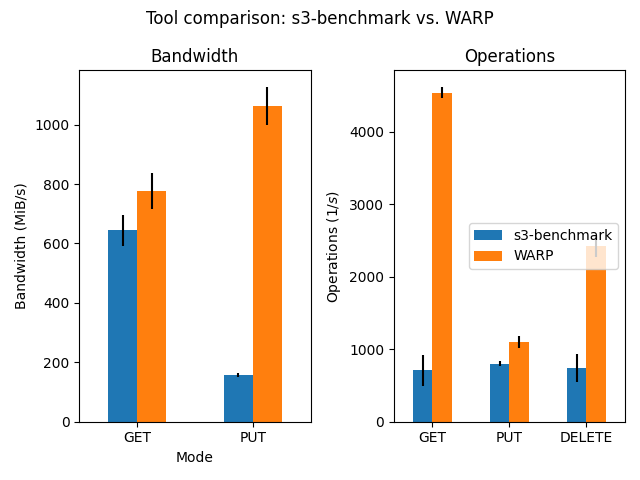

                            mean         std  num
s3-benchmark GET      708.292857  208.375645   14
WARP         GET     4542.232857   77.069324   14
s3-benchmark PUT      802.750000   34.320751   14
WARP         PUT     1105.368571   81.658908   14
s3-benchmark DELETE   739.635714  196.806662   14
WARP         DELETE  2425.240714  155.261849   14


In [12]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_")
folder = Path("./results/compare_s3benchmark_vs_warp")

## Plot code
path = file_prefix if file_prefix else folder


df_get = pd.concat({
    "s3-benchmark": load_data(path, metric="get_bw_in_mibi", suffix="_get_put_a.json"),
    "WARP": load_data(path, metric="get_bw_in_MiB", suffix="_get_put_b.json"),
})
df_get.rename(index={"s3benchmark_vs_warp_get_put_a": "GET", "s3benchmark_vs_warp_get_put_b": "GET"}, inplace=True)

df_put = pd.concat({
    "s3-benchmark": load_data(path, metric="put_bw_in_mibi", suffix="_get_put_a.json"),
    "WARP": load_data(path, metric="put_bw_in_MiB", suffix="_get_put_b.json"),
})
df_put.rename(index={"s3benchmark_vs_warp_get_put_a": "PUT", "s3benchmark_vs_warp_get_put_b": "PUT"}, inplace=True)

df_get_put = pd.concat([df_get, df_put])


df_get_ops = pd.concat({
    "s3-benchmark": load_data(path, metric="get_op_per_s", suffix="get_put_ops_a.json"),
    "WARP": load_data(path, metric="get_ops", suffix="get_put_ops_b.json"),
})
df_put_ops = pd.concat({
    "s3-benchmark": load_data(path, metric="put_op_per_s", suffix="get_put_ops_a.json"),
    "WARP": load_data(path, metric="put_ops", suffix="get_put_ops_b.json"),
})
df_del_ops = pd.concat({
    "s3-benchmark": load_data(path, metric="del_op_per_s", suffix="delete_a.json"),
    "WARP": load_data(path, metric="delete_ops", suffix="delete_b.json"),
})
df_get_ops.rename(index={"s3benchmark_vs_warp_get_put_ops_a": "GET", "s3benchmark_vs_warp_get_put_ops_b": "GET"}, inplace=True)
df_put_ops.rename(index={"s3benchmark_vs_warp_get_put_ops_a": "PUT", "s3benchmark_vs_warp_get_put_ops_b": "PUT"}, inplace=True)
df_del_ops.rename(index={"s3benchmark_vs_warp_delete_a": "DELETE", "s3benchmark_vs_warp_delete_b": "DELETE"}, inplace=True)

df_ops = pd.concat([df_get_ops, df_put_ops, df_del_ops])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Tool comparison: s3-benchmark vs. WARP')

i2 = ["GET","PUT"]
i3 = ["GET","PUT","DELETE"]

def fix_df(df, index):
    """unstack changes the order, fix order and rename index'"""
    df = df.reindex(columns=["s3-benchmark","WARP"], index=index)
    return df

fix_df(df_get_put["mean"].unstack(level=0), i2).plot(
    ax=ax1,
    kind='bar', rot=0,
    xlabel='Mode',
    ylabel='Bandwidth (MiB/s)',
    title=f"Bandwidth",
    yerr=fix_df(df_get_put["std"].unstack(level=0), i2)
)

fix_df(df_ops["mean"].unstack(level=0), i3).plot(
    ax=ax2,
    kind='bar', rot=0,
    xlabel='',
    ylabel='Operations ($1/s$)',
    title="Operations",
    yerr=fix_df(df_ops["std"].unstack(level=0), i3)
)
print(df_ops)

ax1.get_legend().remove()
ax2.legend(loc="center right")
plt.tight_layout()
plt.savefig("s3benchmark_vs_warp.png",bbox_inches='tight')
plt.show()

# Experiment: Daytime evaluation

Netapp A400 & 217 & 539 & 383 & 4 & 55\\
 & 191 & 540 & 384 & 4 & 57\\
Isilon & 250 & 1036 & 791 & 13 & 172\\
 & 297 & 1034 & 785 & 14 & 172\\
Netapp StorageGRID & 428 & 1110 & 1053 & 6 & 78\\
 & 715 & 1110 & 1055 & 6 & 70\\


<IPython.core.display.Javascript object>


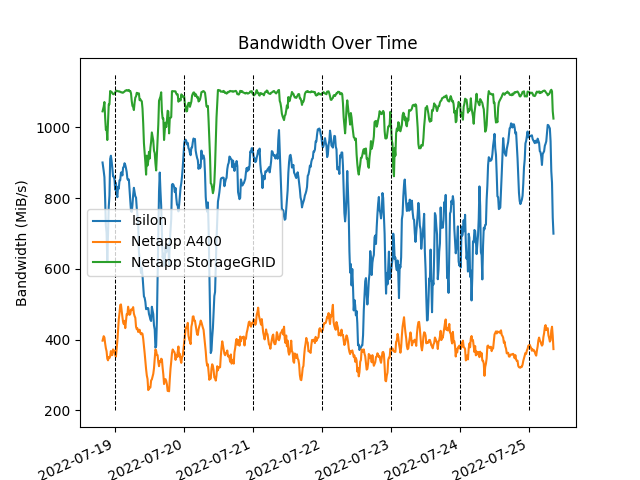

In [13]:
%matplotlib notebook

# Read in results
## Params
folder = Path("./results/daytime_eval")

## Plot code
res = {}


def _load():
    # res: dict[datetime, results]
    # results: dict[tuple[system, num], bw_in_MiB]
    for file in folder.iterdir():
        date_str, _, _, system, num = file.stem.split("_")
        date = datetime.fromisoformat(date_str) + timedelta(hours=2)
        file_content = json.loads(file.read_text())

        run_res = file_content["results"][f"daytime_evaluation_{system}_{num}"]
        if len(run_res) == 0:
            print("No result for:", date_str, system, num)
            continue
        if "put_bw_in_MiB" in run_res[0]:
            value = float(run_res[0]["put_bw_in_MiB"])
        else:
            value = run_res[0]["write_bw_mean_in_MiB"] 

        if date not in res:
            res[date] = {}

        key = (system, int(num))
        if key in res:
            print("Duplication for:", date, key)
        res[date][key] = value

    labels = sorted(k for k in res.keys())
    return labels, res

def generate_tex_table(labels, res):
    # Generate values for tex-table
    values_netapp_1 = []
    values_netapp_2 = []
    values_isilon_1 = []
    values_isilon_2 = []
    values_s3_1 = []
    values_s3_2 = []

    for key in labels:
        value = res[key]
        values_netapp_1.append(value.get(("netapp", 1), 0))
        values_netapp_2.append(value.get(("netapp", 2), 0))
        values_isilon_1.append(value.get(("isilon", 1), 0))
        values_isilon_2.append(value.get(("isilon", 2), 0))
        values_s3_1.append(value.get(("s3", 1), 0))
        values_s3_2.append(value.get(("s3", 2), 0))

    def extract_stats(values, label=""):
        min_, max_ = min(values), max(values)
        avg, conf = sum(values)/len(values), confidence_interval(values)
        std = np.std(values)
        print(f"{label} & {min_:.0f} & {max_:.0f} & {avg:.0f} & {conf:.0f} & {std:.0f}\\\\")

    extract_stats(values_netapp_1, "Netapp A400")
    extract_stats(values_netapp_2)
    extract_stats(values_isilon_1, "Isilon")
    extract_stats(values_isilon_2)
    extract_stats(values_s3_1, "Netapp StorageGRID")
    extract_stats(values_s3_2)

def generate_plot(labels, res):
    # Generate plot
    values_netapp_1 = []
    values_netapp_2 = []
    values_isilon_1 = []
    values_isilon_2 = []
    values_s3_1 = []
    values_s3_2 = []
    ## Sliding windows
    sw_netapp_1 = []
    sw_netapp_2 = []
    sw_isilon_1 = []
    sw_isilon_2 = []
    sw_s3_1 = []
    sw_s3_2 = []

    def calc_sliding_window(value, sw):
        width = 4
        sw.append(value)
        if len(sw) > width:
            sw.pop(0)
        return sum(sw)/len(sw)

    for key in labels:
        value = res[key]
        values_netapp_1.append(calc_sliding_window(value.get(("netapp", 1), 0),sw_netapp_1))
        values_netapp_2.append(calc_sliding_window(value.get(("netapp", 2), 0),sw_netapp_2))
        values_isilon_1.append(calc_sliding_window(value.get(("isilon", 1), 0),sw_isilon_1))
        values_isilon_2.append(calc_sliding_window(value.get(("isilon", 2), 0),sw_isilon_2))
        values_s3_1.append(calc_sliding_window(value.get(("s3", 1), 0),sw_s3_1))
        values_s3_2.append(calc_sliding_window(value.get(("s3", 2), 0),sw_s3_2))

    #plt.plot(labels, values_isilon_1, label="Isilon 01")
    #plt.plot(labels, values_netapp_1, label="Netapp 01")
    #plt.plot(labels, values_s3_1, label="S3 01")
    plt.plot(labels, values_isilon_2, label="Isilon")
    plt.plot(labels, values_netapp_2, label="Netapp A400")
    plt.plot(labels, values_s3_2, label="Netapp StorageGRID")

    # Plot day seperation lines
    for month, day in [(7,19),(7,20),(7,21),(7,22),(7,23),(7,24),(7,25)]:
        x = datetime(year=2022, month=month, day=day)
        plt.vlines(x=x, ymin=200, ymax=1150, linewidth=2, linestyles="dashed", colors="k", linewidths=0.75)
        #x_8, x_17 = x.replace(hour=8), x.replace(hour=17)
        #plt.axvspan(x_8, x_17, color='red', alpha=0.25)

    plt.xticks(rotation=25, ha='right')
    plt.ylabel('Bandwidth (MiB/s)')

    plt.legend()
    plt.title("Bandwidth Over Time")
    plt.savefig("daytime_evaluation.png",bbox_inches='tight')
    plt.show()

labels, res = _load()
generate_tex_table(labels, res)
generate_plot(labels, res)


## Experiment: Compare Storage Systems (bandwidth, iops, latency)

In [17]:
# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_")
folder = Path("./results/benchmark_posix")

## Plot code
path = file_prefix if file_prefix else folder

benchmarks = [
    ("throughput_write", "write_bw_mean_in_MiB"),
    ("throughput_read", "read_bw_mean_in_MiB"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]
dfs = []

for label, metric in benchmarks:
    dfs.append(pd.concat({
        "local": load_data(path, metric=metric, suffix="posix_local.json", x_labels=[label]),
        "nfs_isilon": load_data(path, metric=metric, suffix="posix_isilon.json", x_labels=[label]),
        "nfs_netapp": load_data(path, metric=metric, suffix="posix_netapp.json", x_labels=[label]),
        "nfs_ssdtank": load_data(path, metric=metric, suffix="posix_ssd_tank.json", x_labels=[label]),
        "irodsfs_isilon": load_data(path, metric=metric, suffix="posix_irods_fuse_on_isilon.json", x_labels=[label]),
        "irodsfs_netapp": load_data(path, metric=metric, suffix="posix_irods_fuse_on_netapp.json", x_labels=[label]),
        "irodsfs_s3": load_data(path, metric=metric, suffix="posix_irods_fuse_on_s3.json", x_labels=[label]),
        "webdav_isilon": load_data(path, metric=metric, suffix="posix_irods_davrods_on_isilon.json", x_labels=[label]),
        "webdav_netapp": load_data(path, metric=metric, suffix="posix_irods_davrods_on_netapp.json", x_labels=[label]),
        "webdav_s3": load_data(path, metric=metric, suffix="posix_irods_davrods_on_s3.json", x_labels=[label]),
    }))
    
for df in dfs:
    print(df)

def extract_stats(dfs, benchmark_type, label, index):
    pm = " & $\ \pm\ $ & "  # Plus/minus seperator
    
    print(f"{label}", end="")
    for benchmark, df in zip(benchmarks, dfs):
        if benchmark_type not in benchmark[0]:
            continue
        avg, std = df["mean"][index], df["std"][index]
        if np.isnan(avg) or np.isnan(std):
            print("& &-& ", end="")
        elif "latency" in benchmark[0]:
            print(f"&{avg:.2f}{pm}{std:.2f}", end="")
        else:
            print(f"&{avg:.0f}{pm}{std:.0f}", end="")
    print("\\\\")

print("#"*10)
print("read")
extract_stats(dfs, "read", "local", 0)
extract_stats(dfs, "read", "nfs\_isilon", 1)
extract_stats(dfs, "read", "nfs\_netapp", 2)
extract_stats(dfs, "read", "nfs\_ssdtank", 3)
extract_stats(dfs, "read", "irodsfs\_isilon", 4)
extract_stats(dfs, "read", "irodsfs\_netapp", 5)
extract_stats(dfs, "read", "irodsfs\_s3", 6)
extract_stats(dfs, "read", "webdav\_isilon", 7)
extract_stats(dfs, "read", "webdav\_netapp", 8)
extract_stats(dfs, "read", "webdav\_s3", 9)
print("#"*10)
print("write")
extract_stats(dfs, "write", "local", 0)
extract_stats(dfs, "write", "nfs\_isilon", 1)
extract_stats(dfs, "write", "nfs\_netapp", 2)
extract_stats(dfs, "write", "nfs\_ssdtank", 3)
extract_stats(dfs, "write", "irodsfs\_isilon", 4)
extract_stats(dfs, "write", "irodsfs\_netapp", 5)
extract_stats(dfs, "write", "irodsfs\_s3", 6)
extract_stats(dfs, "write", "webdav\_isilon", 7)
extract_stats(dfs, "write", "webdav\_netapp", 8)
extract_stats(dfs, "write", "webdav\_s3", 9)
print("#"*10)



/home/stefan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:

                                       mean        std  num
local          throughput_write  128.060578   6.146713   16
nfs_isilon     throughput_write  445.967968  54.696129   16
nfs_netapp     throughput_write  370.237354  51.623348   16
nfs_ssdtank    throughput_write  332.996586   2.512257   16
irodsfs_isilon throughput_write  145.969143   3.155809   16
irodsfs_netapp throughput_write  145.492831   4.040569   16
irodsfs_s3     throughput_write         NaN        NaN    0
webdav_isilon  throughput_write  481.487045  24.733831   16
webdav_netapp  throughput_write  495.023286  20.975037   15
webdav_s3      throughput_write         NaN        NaN    0
                                       mean         std  num
local          throughput_read   103.240813    5.642437   16
nfs_isilon     throughput_read   692.785714  214.542098   16
nfs_netapp     throughput_read   223.579847   27.156816   16
nfs_ssdtank    throughput_read   992.937335  115.347483   16
irodsfs_isilon throughput_read   41

/home/stefan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/stefan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Experiment: Compare Storage Systems (metadata ops)

In [19]:
# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_")
folder = Path("./results/benchmark_metadata")

## Plot code
path = file_prefix if file_prefix else folder

metrics = [
    "dir_create",
    "dir_stat",
    "dir_remove",
    "file_create",
    "file_stat",
    "file_read",
    "file_remove",
    #"tree_create",
    #"tree_remove",
]
dfs = []

for metric in metrics:
    dfs.append(pd.concat({
        "local": load_data(path, metric=metric, suffix="metadata_local.json"),
        "nfs\_isilon": load_data(path, metric=metric, suffix="metadata_isilon.json"),
        "nfs\_netapp": load_data(path, metric=metric, suffix="metadata_netapp.json"),
        "nfs\_ssdtank": load_data(path, metric=metric, suffix="metadata_ssd_tank.json"),
        "irodsfs\_isilon": load_data(path, metric=metric, suffix="metadata_irods_fuse_on_isilon.json"),
        "irodsfs\_netapp": load_data(path, metric=metric, suffix="metadata_irods_fuse_on_netapp.json"),
        "irodsfs\_s3": load_data(path, metric=metric, suffix="metadata_irods_fuse_on_s3.json"),
        "webdav\_isilon": load_data(path, metric=metric, suffix="metadata_irods_davrods_on_isilon.json"),
        "webdav\_netapp": load_data(path, metric=metric, suffix="metadata_irods_davrods_on_netapp.json"),
        "webdav\_s3": load_data(path, metric=metric, suffix="metadata_irods_davrods_on_s3.json"),
    }))
for metric,df in zip(metrics, dfs):
    print(metric)
    print(df)
    pass
    
def extract_stats(dfs, num_files, metric_part,label):
    pm = " & $\ \pm\ $ & "  # Plus/minus seperator
    
    print(f"{label}", end="")
    for metric, df in zip(metrics, dfs):
        if metric_part not in metric:
            continue
        current = df.loc[(label, num_files)]
        avg, std = current["mean"], current["std"]
        print(f" & {avg:.0f}{pm}{std:.0f}", end="")
    print("\\\\")

print("#"*10)
extract_stats(dfs, "100000", "dir_", "local")
extract_stats(dfs, "100000", "dir_", "nfs\_isilon")
extract_stats(dfs, "100000", "dir_", "nfs\_netapp")
extract_stats(dfs, "100000", "dir_", "nfs\_ssdtank")
extract_stats(dfs, "1000", "dir_", "irodsfs\_isilon")
extract_stats(dfs, "1000", "dir_", "irodsfs\_netapp")
extract_stats(dfs, "1000", "dir_", "irodsfs\_s3")
extract_stats(dfs, "1000", "dir_", "webdav\_isilon")
extract_stats(dfs, "1000", "dir_", "webdav\_netapp")
extract_stats(dfs, "1000", "dir_", "webdav\_s3")
print("#"*10)
extract_stats(dfs, "100000", "file_", "local")
extract_stats(dfs, "100000", "file_", "nfs\_isilon")
extract_stats(dfs, "100000", "file_", "nfs\_netapp")
extract_stats(dfs, "100000", "file_", "nfs\_ssdtank")
extract_stats(dfs, "1000", "file_", "irodsfs\_isilon")
extract_stats(dfs, "1000", "file_", "irodsfs\_netapp")
extract_stats(dfs, "1000", "file_", "irodsfs\_s3")
extract_stats(dfs, "1000", "file_", "webdav\_isilon")
extract_stats(dfs, "1000", "file_", "webdav\_netapp")
extract_stats(dfs, "1000", "file_", "webdav\_s3")


dir_create
                                mean          std  num
local           10        329.163769   152.234556   13
                100      2071.620385   884.264211   13
                1000    10232.780308  1272.849495   13
                10000    9032.135538   435.179116   13
                100000   9299.858923   175.215523   13
nfs\_isilon     10        195.988000    59.939368   13
                100       793.855385   135.069714   13
                1000     1101.131231   193.412898   13
                10000    1135.692692   194.854261   13
                100000   1143.458308   180.377407   13
nfs\_netapp     10        224.921154    67.818113   13
                100       555.779154   260.472172   13
                1000      624.946077   193.867056   13
                10000     576.150308   176.623132   13
                100000    511.110462   138.396179   13
nfs\_ssdtank    10        164.436385    54.121114   13
                100       444.391923    53.602625   13

# Experiment: Compare storage systems (S3)

In [18]:
# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_")
folder = Path("./results/benchmark_s3")

## Plot code
path = file_prefix if file_prefix else folder

df = pd.concat({
    "bw_get": load_data(path, metric="get_bw_in_MiB", suffix="s3_warp_get_put.json"),
    "bw_put": load_data(path, metric="put_bw_in_MiB", suffix="s3_warp_get_put.json"),
    "ops_get": load_data(path, metric="get_ops", suffix="s3_warp_get_put_ops.json"),
    "ops_put": load_data(path, metric="put_ops", suffix="s3_warp_get_put_ops.json"),
    "ops_del": load_data(path, metric="delete_ops", suffix="s3_warp_delete.json"),
})
df.index = df.index.droplevel(1)

print(df)

df_r_bw = df.loc[("bw_get")]
df_w_bw = df.loc[("bw_put")]
df_r_iops = df.loc[("ops_get")]
df_w_iops = df.loc[("ops_put")]

pm = " & $\ \pm\ $ & "
print("#"*10)
print("Read Bandwidth")
print("s3\_netapp ", end="")
print(f"& {df_r_bw['mean']:.0f}{pm}{df_r_bw['std']:.0f}", end="")
print(f"& {df_r_iops['mean']:.0f}{pm}{df_r_iops['std']:.0f}", end="")
print("\\\\")

print("#"*10)
print("Write Bandwidth")
print("s3\_netapp ", end="")
print(f"& {df_w_bw['mean']:.0f}{pm}{df_w_bw['std']:.0f}", end="")
print(f"& {df_w_iops['mean']:.0f}{pm}{df_w_iops['std']:.0f}", end="")
print("\\\\")

                mean         std  num
bw_get    791.015000   30.901982   16
bw_put   1066.654375   60.888718   16
ops_get  4501.262500  143.819740    8
ops_put  1060.538750  104.157789    8
ops_del  2515.205000  124.952359   16
##########
Read Bandwidth
s3\_netapp & 791 & $\ \pm\ $ & 31& 4501 & $\ \pm\ $ & 144\\
##########
Write Bandwidth
s3\_netapp & 1067 & $\ \pm\ $ & 61& 1061 & $\ \pm\ $ & 104\\


# Experiment: Different access points for SSD Tank


<IPython.core.display.Javascript object>


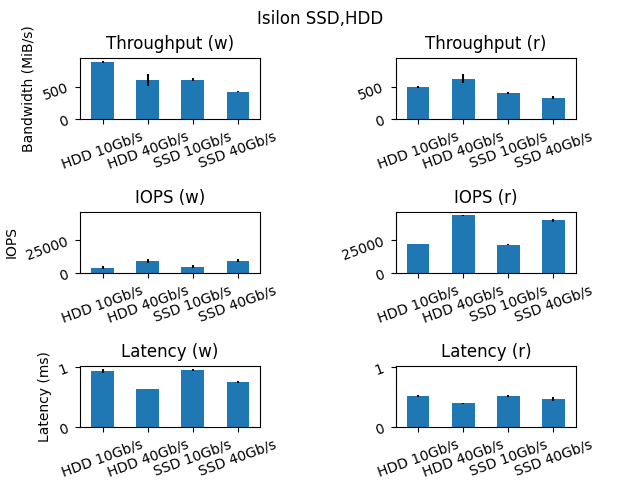

---------
Throughput write
                  mean        std
HDD 10Gb/s  878.803601  18.709457
HDD 40Gb/s  600.292803  87.651497
SSD 10Gb/s  606.877758  26.572561
SSD 40Gb/s  421.088637   9.143627
---------
Throughput read
                  mean        std
HDD 10Gb/s  492.820954  19.354635
HDD 40Gb/s  621.963134  65.783003
SSD 10Gb/s  395.877308  17.819422
SSD 40Gb/s  327.628254  22.662875
---------
IOPS write
                   mean          std
HDD 10Gb/s  4318.617123   940.576233
HDD 40Gb/s  9052.378237  1452.820299
SSD 10Gb/s  4953.676898  1122.344462
SSD 40Gb/s  9609.892948  1136.503413
---------
IOPS read
                    mean          std
HDD 10Gb/s  22353.215900   187.161457
HDD 40Gb/s  43927.077824   693.896096
SSD 10Gb/s  21739.072803   154.185243
SSD 40Gb/s  40184.774059  1188.841197
---------
Latency write
                mean       std
HDD 10Gb/s  0.936706  0.027597
HDD 40Gb/s  0.636252  0.005675
SSD 10Gb/s  0.958689  0.016840
SSD 40Gb/s  0.745047  0.017858
---------
La

In [38]:
%matplotlib notebook

## Params
result_file_prefix = "2022-06-08T19:53:53_benchmark"

## Plot code
hdd_s = load_json(f"./results/{result_file_prefix}_isilon_hdd.json")
hdd_f = load_json(f"./results/{result_file_prefix}_isilon_hdd_fast.json")
ssd_s = load_json(f"./results/{result_file_prefix}_isilon_ssd.json")
ssd_f = load_json(f"./results/{result_file_prefix}_isilon_ssd_fast.json")

benchmarks = [
    ("throughput_write", "write_bw_mean_in_MiB"),
    ("throughput_read", "read_bw_mean_in_MiB"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

dfs = []
for label, metric in benchmarks:
    dfs.append(pd.concat([
        extract_results(hdd_s, metric, [label]).rename(index={label: "HDD 10Gb/s"}),
        extract_results(hdd_f, metric, [label]).rename(index={label: "HDD 40Gb/s"}),
        extract_results(ssd_s, metric, [label]).rename(index={label: "SSD 10Gb/s"}),
        extract_results(ssd_f, metric, [label]).rename(index={label: "SSD 40Gb/s"}),
    ]))

    
fig, axis = plt.subplots(3, 2)
fig.suptitle('Isilon SSD,HDD')
plt.subplots_adjust(wspace=0.7500, hspace=1.5)
    
dfs[0]["mean"].plot(
    ax=axis[0][0],
    kind='bar', rot=0,
    ylabel='Bandwidth (MiB/s)',
    title='Throughput (w)',
    yerr=dfs[0]["std"],
)
dfs[1]["mean"].plot(
    ax=axis[0][1],
    kind='bar', rot=0,
    title='Throughput (r)',
    yerr=dfs[1]["std"],
)

dfs[2]["mean"].plot(
    ax=axis[1][0],
    kind='bar', rot=0,
    ylabel='IOPS',
    title='IOPS (w)',
    yerr=dfs[2]["std"]
)

dfs[3]["mean"].plot(
    ax=axis[1][1],
    kind='bar', rot=0,
    title='IOPS (r)',
    yerr=dfs[3]["std"],
)
dfs[4]["mean"].plot(
    ax=axis[2][0],
    kind='bar', rot=0,
    ylabel='Latency (ms)',
    title='Latency (w)',
    yerr=dfs[4]["std"]
)
dfs[5]["mean"].plot(
    ax=axis[2][1],
    kind='bar', rot=0,
    title='Latency (r)',
    yerr=dfs[5]["std"],
)

axis[0][1].sharey(axis[0][0])
axis[1][0].sharey(axis[1][1])
axis[2][1].sharey(axis[2][0])
for i,j in [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]:
    axis[i][j].tick_params(labelrotation=20)
    # axis[i][j].get_legend().remove()
    
#plt.tight_layout()
# plt.savefig("paramstudy_throughput.png",bbox_inches='tight')
plt.show()

print("---------", "Throughput write", sep="\n")
print(dfs[0])
print("---------", "Throughput read", sep="\n")
print(dfs[1])
print("---------", "IOPS write", sep="\n")
print(dfs[2])
print("---------", "IOPS read", sep="\n")
print(dfs[3])
print("---------", "Latency write", sep="\n")
print(dfs[4])
print("---------", "Latency read", sep="\n")
print(dfs[5])



# Experiment: Galaxy

['1000x1K', '100x1K', '10x1K', '1x0', '1x1G', '1x1K', '1x1M', '2000x1K']
dict_keys(['irods_on_s3', 'irods_via_davrods_on_s3', 'isilon', 'irods_via_davrods_on_isilon', 'irods_on_isilon', 'netapp', 's3', 'ssd_tank'])


<IPython.core.display.Javascript object>


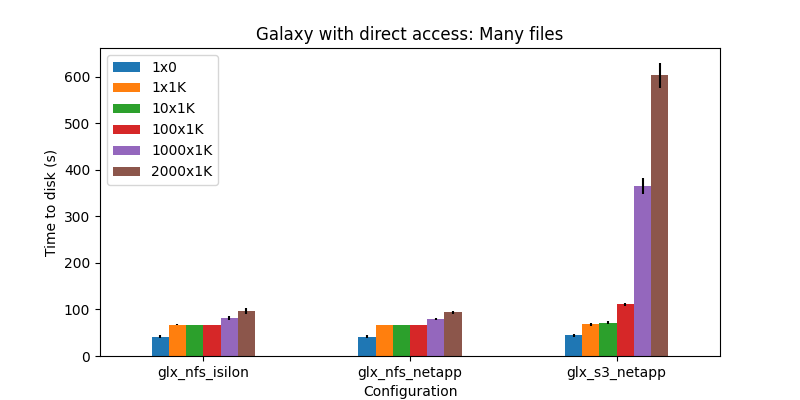

<IPython.core.display.Javascript object>


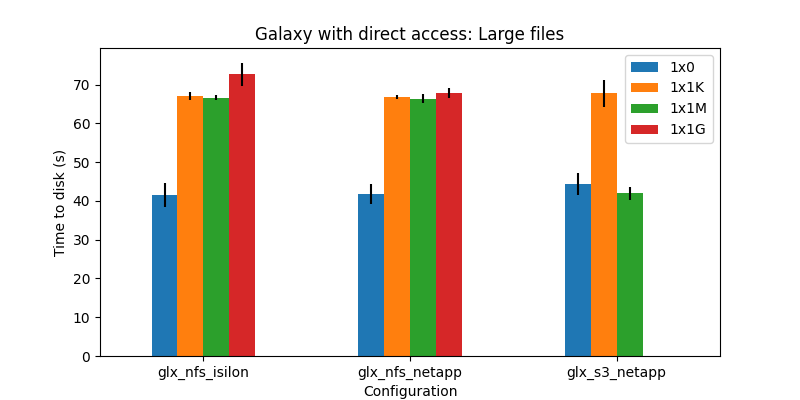

<IPython.core.display.Javascript object>


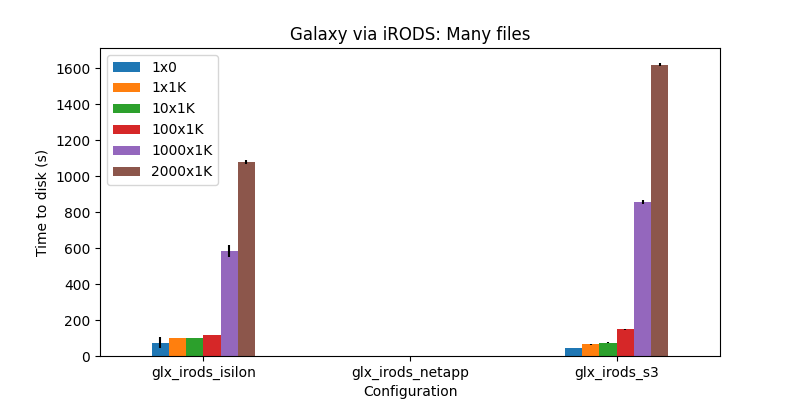

<IPython.core.display.Javascript object>


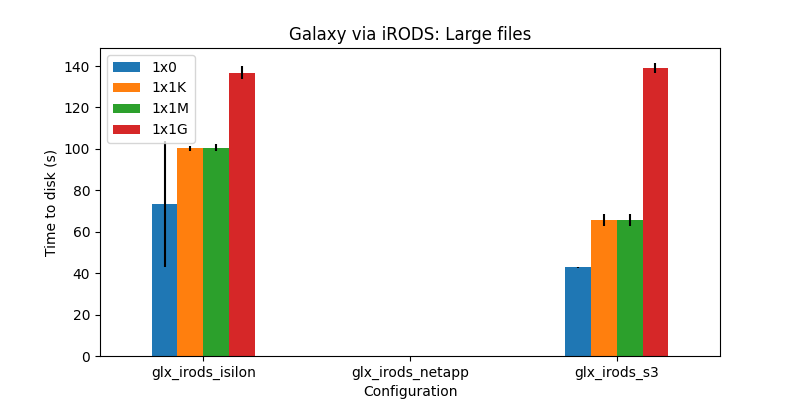

<IPython.core.display.Javascript object>


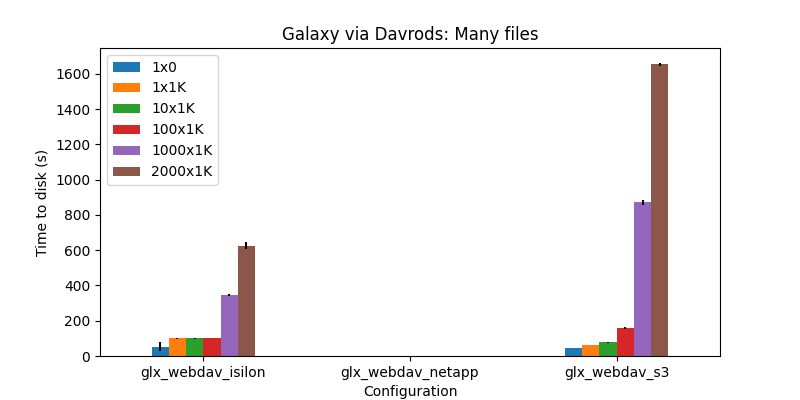

<IPython.core.display.Javascript object>


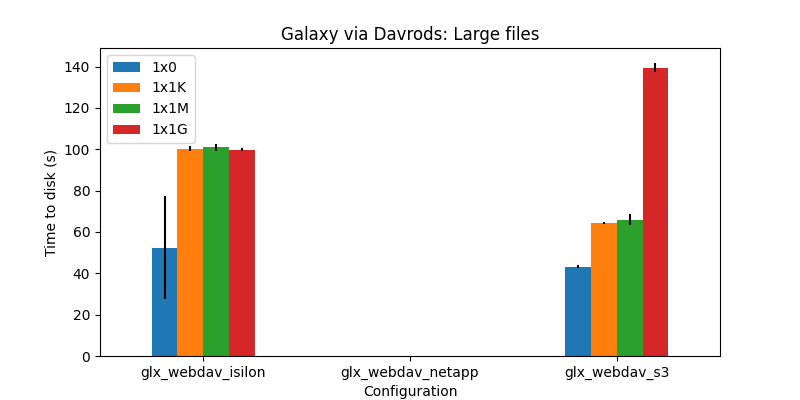

<IPython.core.display.Javascript object>


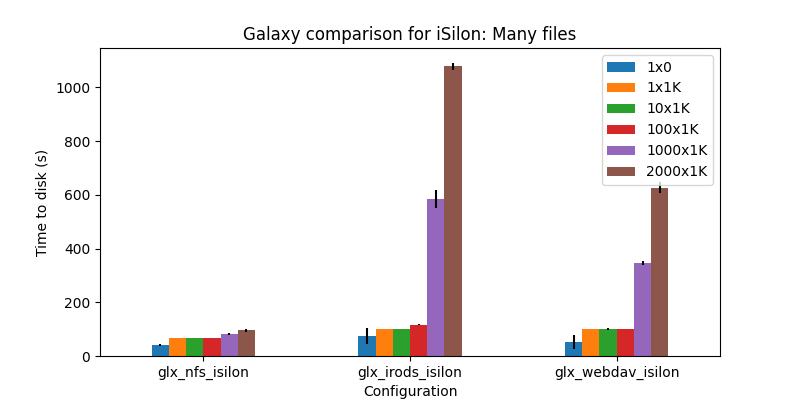

<IPython.core.display.Javascript object>


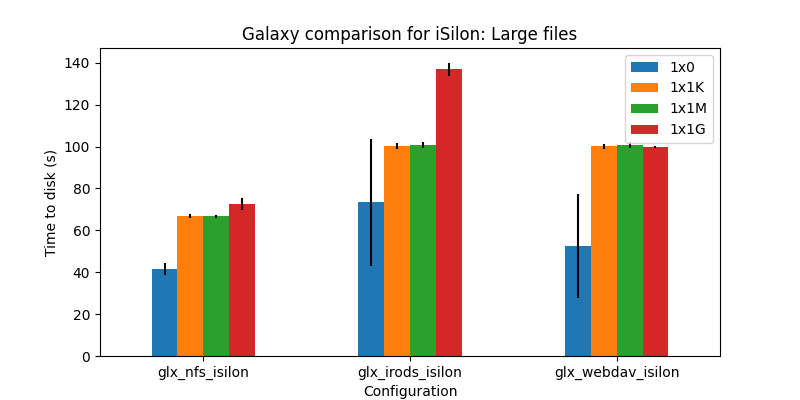

In [86]:
%matplotlib notebook

# Read in results
## Params
folder = Path("./results/galaxy")

## Plot code
res = {}


def _load():
    # res: dict[benchmark, results]
    # results: dict[target, list[total_runtime_in_s]]
    for file in folder.iterdir():
        date_str, _, _, benchmark, *target, _ = file.stem.split("_")
        target = "_".join(target)
        file_content = json.loads(file.read_text())

        run_res = file_content["results"][f"benchmark_galaxy_{benchmark}_{target}_backend"]
        if len(run_res) == 0:
            print("No result for:", date_str, benchmark, target)
            continue
        value = float(run_res[0]["total_runtime_in_s"])

        if benchmark not in res:
            res[benchmark] = {}

        if target not in res[benchmark]:
            res[benchmark][target] = []
        res[benchmark][target].append(value)

    labels = sorted(k for k in res.keys())
    return labels, res

def _extract_results(data, labels):
    pd_data = []
    for label in labels:
        values = data[label] if label in data else [0]
        mean = np.mean(values)
        #conf = confidence_interval(values)
        std = np.std(values)
        pd_data.append([mean, std])


    df = pd.DataFrame(data=pd_data, index=labels, columns=["mean", "std"])
    return df

def generate_plot(res, configs, benchmarks, title):
    data = {}
    for b in benchmarks:
        data[b] = _extract_results(res[b], configs)
    df = pd.concat(data)

    def fix_df(df):
        """unstack changes the order, fix order and rename index'"""
        df = df.reindex(index=configs, columns=benchmarks)
        df.rename(index={"isilon": "glx_nfs_isilon", "netapp": "glx_nfs_netapp", "s3": "glx_s3_netapp"}, inplace=True)
        df.rename(index={"irods_on_isilon": "glx_irods_isilon", "irods_on_netapp": "glx_irods_netapp", "irods_on_s3": "glx_irods_s3"}, inplace=True)
        df.rename(index={"irods_via_davrods_on_isilon": "glx_webdav_isilon", "irods_via_davrods_on_netapp": "glx_webdav_netapp", "irods_via_davrods_on_s3": "glx_webdav_s3"}, inplace=True)
        return df

    df_mean = fix_df(df["mean"].unstack(level=0))
    df_std = fix_df(df["std"].unstack(level=0))
    df_mean.plot(
        kind='bar', rot=0,
        xlabel='Configuration',
        ylabel='Time to disk (s)',
        figsize=(8, 4),
        yerr=df_std
    )

    plt.legend()
    plt.title(title)
    plt.savefig(title.lower().replace(" ", "_").replace(":","")+".png",bbox_inches='tight')
    plt.show()

labels, res = _load()
print(labels)
print(res["1x0"].keys())
many_files = ["1x0", "1x1K", "10x1K", "100x1K", "1000x1K", "2000x1K"]
large_files = ["1x0", "1x1K", "1x1M", "1x1G", ] #"10x1G"]

generate_plot(res, ["isilon", "netapp", "s3"], many_files, "Galaxy with direct access: Many files")
generate_plot(res, ["isilon", "netapp", "s3"], large_files, "Galaxy with direct access: Large files")

generate_plot(res, ["irods_on_isilon", "irods_on_netapp", "irods_on_s3"], many_files, "Galaxy via iRODS: Many files")
generate_plot(res, ["irods_on_isilon", "irods_on_netapp", "irods_on_s3"], large_files, "Galaxy via iRODS: Large files")

generate_plot(res, ["irods_via_davrods_on_isilon", "irods_via_davrods_on_netapp", "irods_via_davrods_on_s3"], many_files, "Galaxy via Davrods: Many files")
generate_plot(res, ["irods_via_davrods_on_isilon", "irods_via_davrods_on_netapp", "irods_via_davrods_on_s3"], large_files, "Galaxy via Davrods: Large files")

generate_plot(res, ["isilon", "irods_on_isilon", "irods_via_davrods_on_isilon"], many_files, "Galaxy comparison for iSilon: Many files")
generate_plot(res, ["isilon", "irods_on_isilon", "irods_via_davrods_on_isilon"], large_files, "Galaxy comparison for iSilon: Large files")

